This notebook is an extension of what I learnd from Jed's class (see his notebook https://github.com/cu-numcomp)

In [1]:
using Plots
using LinearAlgebra
using SparseArrays
using FastGaussQuadrature
using NLsolve
using Test

In [2]:
default(linewidth=3)

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

my_spy (generic function with 1 method)

## Ciarlet (1978) definition

A **finite element** is a triple $(K, P, N)$ where
* $K$ is a bounded domain with piecewise smooth boundary
* $P = \{p_j\}_1^k$ is a finite-dimensional function space over $K$ ("prime basis")
* $N = \{n_i\}_1^k$ is a basis for the dual space ("nodes")

It is common for nodes to be pointwise evaluation
$$ \langle n_i, p_j \rangle = p_j(x_i) $$

We use **Legendre polynomials** as a prime basis. 

In [3]:
function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square matrix by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

vander_legendre_deriv (generic function with 2 methods)

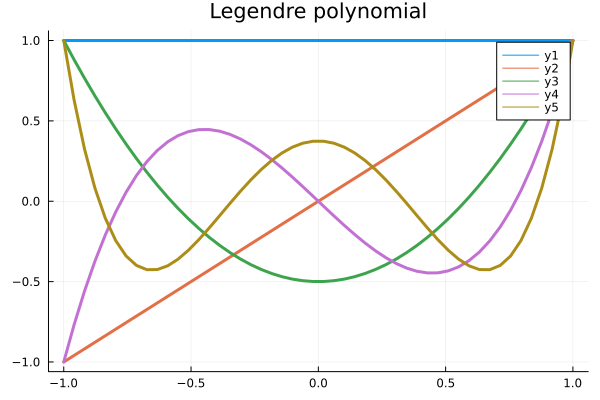

In [4]:
x = LinRange(-1, 1, 50)
P, dP = vander_legendre_deriv(x, 5)
plot(x, P, title = "Legendre polynomial",)

# Prime to nodal basis
(see sec 4.3 of fenics book)

We use the prime basis $\{ p \}_{i=1}^n$ (here legendre polynomials) that spans the finite element space $P$ to construct nodal basis $\phi_j$

$$
\phi_j = \sum_{k=1}^n \alpha_{jk} p_k
$$

A **nodal basis** $\{ \phi_j(x) \}$ is one that satisfies
$ n_i(\phi_j) = \delta_{ij} . $

$$
\delta_{ij} = \sum_{k=1}^n n_i(\alpha_{jk} p_k) =  \sum_{k=1}^n \alpha_{jk} n_i(p_k) = \sum_{k=1}^n \alpha_{jk} V_{ik}
$$

in matrix notation
$$
I = V \alpha^T \Longrightarrow  \alpha = V^{-T}
$$

We write $\phi_j$ as (since we multiply $p$ from the right we removed the transpose),
$$ \phi_j(x) = \sum_k p_k(x) (V^{-1})_{k,j} . $$

and the derivative of nodal basis is
$$ d\phi_j(x) = \sum_k dp_k(x) (V^{-1})_{k,j} . $$

# 1D element [-1, 1] with evenly spaced nodes

For higher order we will have ill-conditioned problem if we use evenly spaced nodes. See figures below.

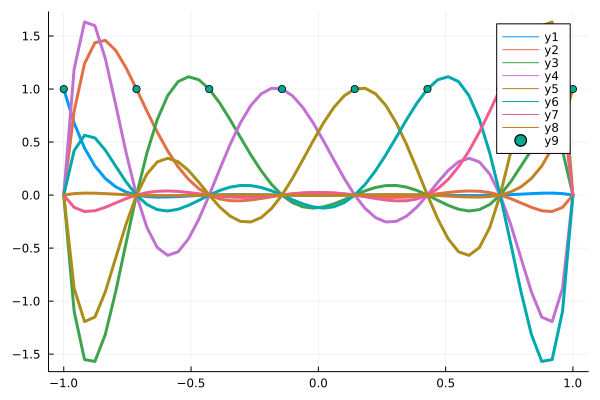

In [5]:
k = 8
xn = LinRange(-1, 1, k)
V, _ = vander_legendre_deriv(xn)
xx = LinRange(-1, 1, 50)
Pxx, _ = vander_legendre_deriv(xx, k) # p_k(x) computed at 50 points
Pn = Pxx / V  # \phi(x) = p * V^{-1} nodal basis
plot(xx, Pn)
scatter!(xn, one.(xn))

# 1D element [-1, 1] with nodes located at Lobatto points

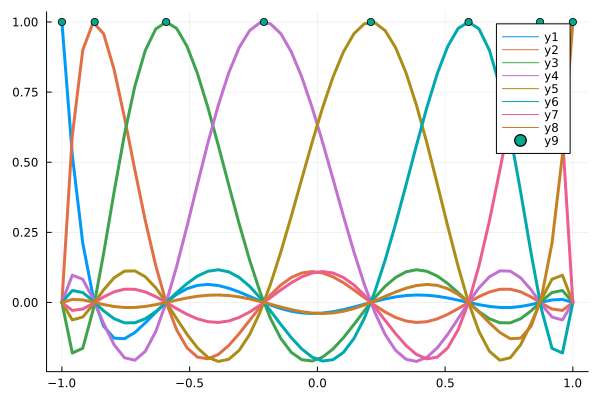

In [6]:
xn, _ = gausslobatto(k)
V, _ = vander_legendre_deriv(xn)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))

# Galerkin method: $L^2$ projection on ref element [-1,1]

A nice test problem that doesn't require derivatives or boundary conditions:
Find $u \in \mathcal V_h$ such that
$$ \int_{-1}^1 v(x) \big[ u(x) - f(x) \big] = 0, \quad \forall v \in \mathcal V_h$$

In [7]:
function febasis(P, Q, Qmode)
    x, _ = gausslobatto(P)
    if Qmode == "GAUSS"
        q, w = gausslegendre(Q)
    elseif Qmode == "GLL"
        q, w = gausslobatto(Q)
    else
        error("Qmode error! Choose GAUSS or GLL Quadrature points!");
    end
    V, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / V
    D = Dp / V
    x, q, w, B, D
end

function L2_galerkin(P, Q, f, Qmode)
    x, q, w, B, _ = febasis(P, Q, Qmode)
    A = B' * diagm(w) * B  # v^T * u
    rhs = B' * diagm(w) * f.(q)  # v^T * f
    # Jacobi-preconditioned mass matrix
    #@show cond(A)
    #@show cond(diagm(1 ./diag(A))*A)
    u = (diagm(1 ./diag(A))*A) \ (diagm(1 ./diag(A))*rhs)
    #u = A \ rhs

    x, u
end

L2_galerkin (generic function with 1 method)

In [8]:
_, _, _, B, _ = febasis(2, 3, "GAUSS")
B

3×2 Matrix{Float64}:
 0.887298  0.112702
 0.5       0.5
 0.112702  0.887298

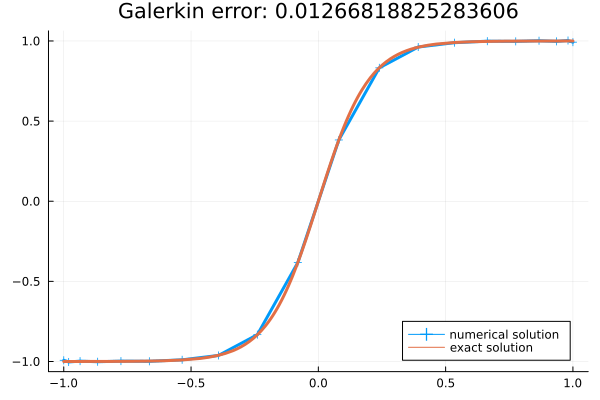

In [9]:
f(x) = tanh(5*x)
x, u = L2_galerkin(20, 20, f, "GAUSS")
err = u - f.(x)
plot(x, u, marker=:auto, legend=:bottomright, label = "numerical solution")
plot!(f, title="Galerkin error: $(norm(err))", label="exact solution")

### Try few quadrature points and see condition numbers of A ($P > Q$) 

# Convergence of the Galerkin method for L2 projection

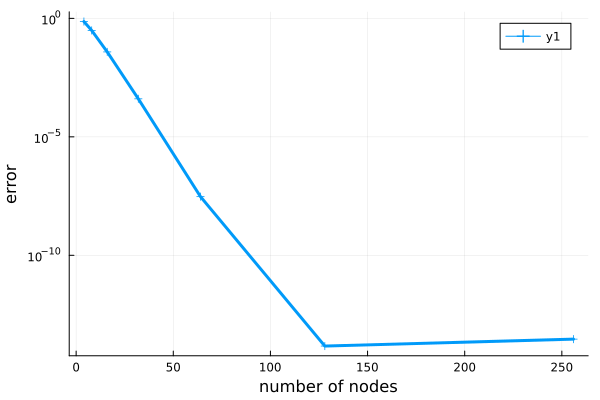

In [10]:
ns = 2 .^ (2:8)
function L2_error(n, Qmode)
    x, u = L2_galerkin(n, n, f, Qmode)
    norm(u - f.(x))
end
plot(ns, L2_error.(ns,"GAUSS"), marker=:auto, yscale=:log10, xlabel="number of nodes", ylabel="error")

# Test Grad mode on the reference element

In [11]:
eval(x) = @. x^2
eval_grad(x) = @. 2*x

eval_grad (generic function with 1 method)

In [12]:
P, Q = 2, 3
x, q, w, BL, _ = febasis(P, Q, "GLL")
x, q, w, _, Du = febasis(Q, Q, "GAUSS")
x, q, w, Bx, _ = febasis(P, Q, "GAUSS")

X = [-1, 1]
X_q = BL*X
U = eval(X_q[:,1])
Gh = Du*U;
X_q1 = Bx * X;
Ge = eval_grad(X_q1);
@test Gh ≈ Ge

Test Passed
  Expression: Gh ≈ Ge
   Evaluated: [-1.5491933384829668, 0.0, 1.5491933384829668] ≈ [-1.5491933384829668, 0.0, 1.5491933384829668]

# Galerkin method for Poisson on ref element [-1,1]

$$ \int_{\Omega} \nabla v \cdot \kappa \cdot \nabla u = \int_{\Omega} v f, \forall v$$

In [13]:
function poisson_galerkin(P, Q, kappa, f, Qmode)
    x, q, w, B, D = febasis(P, Q, Qmode)
    A = D' * diagm(w .* kappa.(q)) * D
    rhs = B' * diagm(w) * f.(q)
    # Dirichlet Boundary conditions
    rhs[[1,end]] .= 0
    A[1, :] .= 0
    A[1, 1] = 1
    A[end, :] .= 0
    A[end, end] = 1
    u = A \ rhs
    x, u
end

poisson_galerkin (generic function with 1 method)

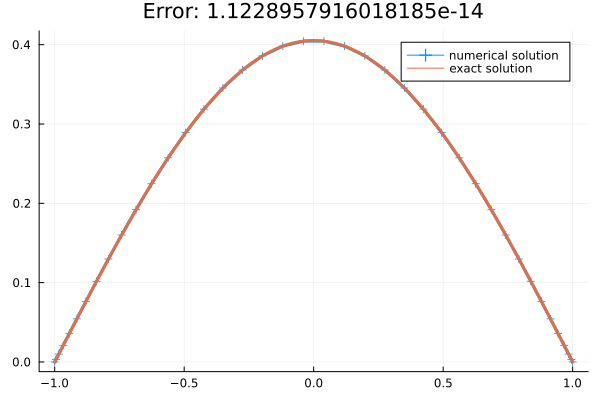

In [14]:
# case kappa=1
f(x) = cos(x*pi/2)
x, u = poisson_galerkin(40, 40, one, f, "GAUSS")
plot(x, u, marker=:auto, label = "numerical solution")
uexact(x) = cos(x*pi/2) * (2/pi)^2
plot!(uexact, title="Error: $(norm(u - uexact.(x)))", label = "exact solution")

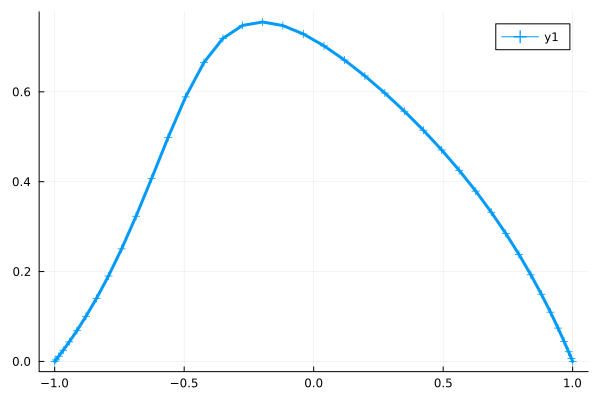

In [15]:
# arbitrary kappa
kappa(x) = 0.6 .+ 0.4 * sin.(pi*x)
x, u = poisson_galerkin(40, 40, kappa, x -> cos(x*pi/2), "GAUSS")
plot(x, u, marker=:auto)

### if we apply Neumann on both sides we get singular matrix

Because we have function that second derivative is zero and the first derivative is zero on the boundaries, so we get constant function. So we need at least one boundary condition.

In [16]:
x, q, w, B, D = febasis(7, 10, "GAUSS")
A = D' * diagm(w .* kappa.(q)) * D
@show norm(A - A')
eigvals(A)

norm(A - A') = 9.893782475477695e-16


7-element Vector{Float64}:
  6.743090009808461e-16
  0.21130426481190825
  1.386614254074465
  3.270120000067312
  6.853818219483849
 10.692355373099769
 14.545787888462765

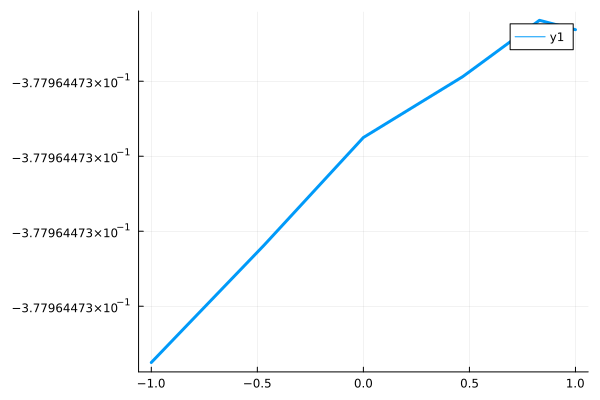

GKS: Possible loss of precision in routine SET_WINDOW


In [17]:
L, X = eigen(A)
plot(x, X[:,1])

# Convergence of the Galerkin method for Poisson

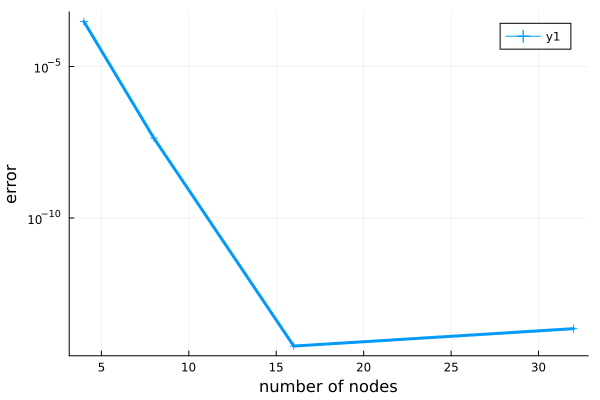

In [18]:
ns = 2 .^ (2:5)
function L2_error(n, Qmode)
    x, u = poisson_galerkin(n, n, one, f, Qmode)
    norm(u - uexact.(x))
end
plot(ns, L2_error.(ns, "GAUSS"), marker=:auto, yscale=:log10, xlabel="number of nodes", ylabel="error")

# Combine both on one element [xL,xR]

We solve

$$
\kappa \nabla^2 u + u = f
$$

Weak form

$$
\int v \nabla u \cdot n - \int \nabla v \kappa \nabla u + \int v u = \int v f
$$


We need to update each row of $D = \frac{\partial v}{\partial X}$ by jacobian $dX/dx$.

In [19]:
function general_galerkin(P, Q, kappa, f, Qmode; xL=0, xR=1)
    x, q, w, B, D = febasis(P, Q, Qmode)
    
    x = (xL + xR)/2 .+ (xR - xL)/2*x
    q = (xL + xR)/2 .+ (xR - xL)/2*q
    w = (xR - xL)/2 * w
    dXdx = ones(Q) * 2 / (xR - xL)
    K = (D' .* dXdx) * diagm(w .* kappa.(q)) * (dXdx .* D)
    M = B' * diagm(w) * B  # v^T * u
    rhs = B' * diagm(w) * f.(q)
    
    A = M - K
    # Dirichlet Boundary conditions
    rhs[[1,end]] .= 0
    A[1, :] .= 0
    A[1, 1] = 1
    A[end, :] .= 0
    A[end, end] = 1
    u = A \ rhs
    x, u
end

general_galerkin (generic function with 1 method)

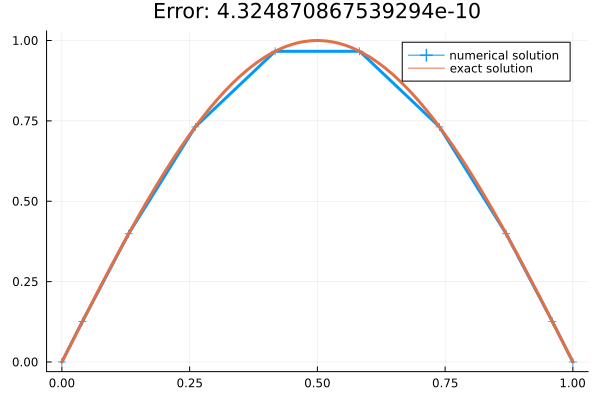

In [20]:
# case kappa=1
P = 10
Q = 10
f(x) = (1-pi^2) * sin(x*pi)
x, u = general_galerkin(P, Q, one, f, "GAUSS")
plot(x, u, marker=:auto, label = "numerical solution")
uexact(x) = sin(x*pi)
plot!(uexact, title="Error: $(norm(u - uexact.(x)))", label = "exact solution")

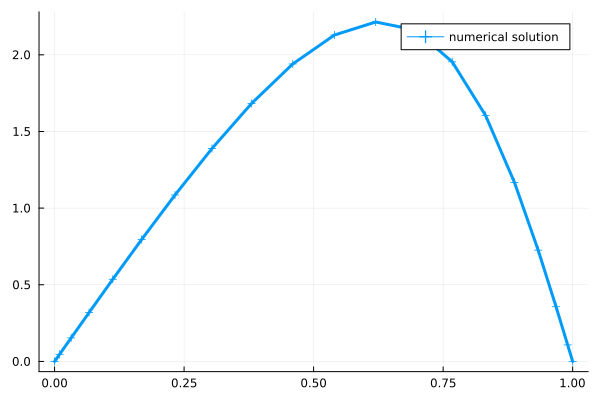

In [21]:
# arbitrary kappa
P = 20
Q = 20
kappa(x) = 0.6 .+ 0.4 * cos.(pi*x)
x, u = general_galerkin(P, Q, kappa, f, "GAUSS")
plot(x, u, marker=:auto, label = "numerical solution")

# <font color='red'> Multiple Elements: Define connectivity for Assembly

In [22]:
function GetConnectivity(P, nelx)
    """This function returns the connectivity array

    1----2----3----4----5
    
    local numbering of one element is

    1---...----P


    Input:
    ------
    nelx: number of element in x direction start from 1 
    Output:
    ------
    IEN: connectivity array of size P x () based on node numbering
    We need IENn to find the coordinate of nodes in assembly
    """
    # number of element
    num_elem = nelx
    # number of nodes in x-direction
    nodex = nelx + 1
    IEN = zeros(Int64, P,num_elem)
    for e=1:nelx
        for i=1:P 
            IEN[i,e] = i + (e-1)*(P-1)
        end
    end

    return IEN
end

function GetElementRestriction(IEN, e)
    """
    This function is map between local to global dof or element restriction operator.
    We use this function to scatter the local vector or matrix
    to global vector or matrix in assembly process
    """
    global_dof = maximum(IEN)
    # local dof number
    P = size(IEN,1)
    temp = zeros(Int64, P, 1)
    
    temp[:,1] = IEN[:,e]
    # element restriction operator
    L = spzeros(P, global_dof)
    for i=1:P
        L[i, IEN[i,e] ] = 1
    end

    return L 
end

GetElementRestriction (generic function with 1 method)

In [23]:
function GetFESolution(P, Q, kappa, f, Qmode, IEN; a=0, b=1)

    # coordinate, quadrature, and basis on reference element [-1,1]
    x_ref, q_ref, w_ref, B, D = febasis(P, Q, Qmode)

    num_elem = size(IEN,2)
    global_dof = maximum(IEN)
    F = zeros(global_dof, 1)
    A = zeros(global_dof,global_dof)
    # Divide domain [a,b] to num_elem
    x = LinRange(a, b, num_elem+1)
    # Store nodal coordinate in xn
    xn = Float64[]
    
    for e=1:num_elem
        # Get coordinate of the end nodes of each element
        xL, xR = x[e:e+1]
        # Nodal coordinate of each element
        xe = (xL + xR)/2 .+ (xR - xL)/2 * x_ref[1+(e>1):end]
        # Store nodal coordinates
        append!(xn, xe)
        # Update quadrature
        q = (xL + xR)/2 .+ (xR - xL)/2 * q_ref
        w = (xR - xL)/2 * w_ref
        # Jacobian
        dXdx = ones(Q) * 2 / (xR - xL)
        # Local operators
        Ke = (D' .* dXdx) * diagm(w .* kappa.(q)) * (dXdx .* D)
        Me = B' * diagm(w) * B  # v^T * u
        Fe = B' * diagm(w) * f.(q)
        E = GetElementRestriction(IEN, e)
        
        Ae = Me - Ke
        # Assemble
        A = A + E' * Ae * E
        F = F + E' * Fe

    end
    
    # Dirichlet Boundary conditions
    F[[1,end]] .= 0
    A[1, :] .= 0
    A[1, 1] = 1
    A[end, :] .= 0
    A[end, end] = 1
    u = A \ F
    
   return x, xn, u 
end

GetFESolution (generic function with 1 method)

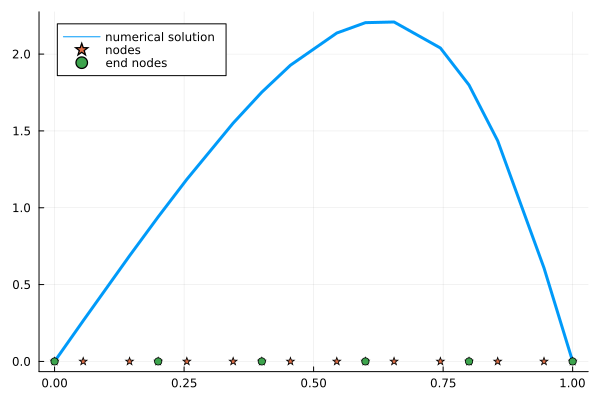

In [24]:
P = 4
Q = P
nelx = 5
IEN = GetConnectivity(P, nelx)
f(x) = (1-pi^2) * sin(x*pi)
kappa(x) = 0.6 .+ 0.4 * cos.(pi*x)
x, xn, u = GetFESolution(P, Q, kappa, f, "GAUSS", IEN; a=0, b=1)
plot(xn, u, label = "numerical solution", )
scatter!(xn, zero, marker=:star, label = "nodes")
scatter!(x, zero, marker=:circle, label = "end nodes", legend=:topleft)

# Computing Residual instead of solving u = A\ F
It is common in FE courses that we solve the problem like what we did in GetFESolution function. Another approach is to compute the residual (A*u - F) and solve it with NLSolve package as follow

In [25]:
function xnodal(x, P)
    num_elem = length(x) - 1
    xn = Float64[]
    x_ref, _ = gausslobatto(P)
    for e in 1:num_elem
        # Get coordinate of the end nodes of each element
        xL, xR = x[e:e+1]
        # Nodal coordinate of each element
        xe = (xL + xR)/2 .+ (xR - xL)/2 * x_ref[1+(e>1):end]
        # Store nodal coordinates
        append!(xn, xe)
    end
    xn
end

xnodal (generic function with 1 method)

In [26]:
struct FESpace
    a::Float64
    b::Float64
    P::Int
    Q::Int
    num_elem::Int
    x::Vector
    xn::Vector
    IEN::Matrix
    function FESpace(a, b, P, Q, num_elem)
        x = LinRange(a, b, num_elem+1)
        xn = xnodal(x, P)
        IEN = GetConnectivity(P, num_elem)
        
        new(a, b, P, Q, num_elem, x, xn, IEN)
    end
end

In [27]:
function fe_element(fe, e)
    # coordinate, quadrature, and basis on reference element [-1,1]
    x_ref, q_ref, w_ref, B, D = febasis(fe.P, fe.Q, "GAUSS")
    # Get coordinate of the end nodes of each element
    xL, xR = fe.x[e:e+1]
    # Update quadrature
    q = (xL + xR)/2 .+ (xR - xL)/2 * q_ref
    w = (xR - xL)/2 * w_ref
    # Jacobian
    dXdx = ones(fe.Q) * 2 / (xR - xL)
    # Element restriction
    E = GetElementRestriction(fe.IEN, e)
    E = sparse(E)
    q, w, E, dXdx, B, D
end

fe_element (generic function with 1 method)

In [28]:
# This function is exactly the same as GetFESolution but we return residual (A*u - F)
function ComputeResidual(u_in, fe, kappa, f)

    global_dof = maximum(fe.IEN)
    F = zeros(global_dof, 1)
    A = zeros(global_dof,global_dof)
    
    for e=1:fe.num_elem
        q, w, E, dXdx, B, D = fe_element(fe, e)
        # Local operators
        Ke = (D' .* dXdx) * diagm(w .* kappa.(q)) * (dXdx .* D)
        Me = B' * diagm(w) * B  # v^T * u
        Fe = B' * diagm(w) * f.(q)        
        Ae = Me - Ke
        # Assemble
        A = A + E' * Ae * E
        F = F + E' * Fe

    end
    
    # Dirichlet Boundary conditions
    F[[1,end]] .= 0
    A[1, :] .= 0
    A[1, 1] = 1
    A[end, :] .= 0
    A[end, end] = 1
    
   return A*u_in - F 
end

ComputeResidual (generic function with 1 method)

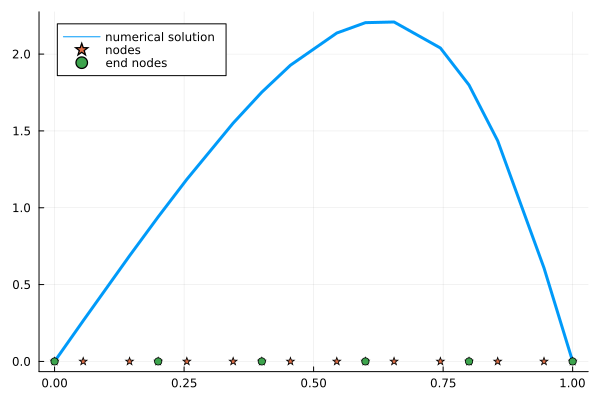

In [29]:
fe = FESpace(0, 1, 4, 4, 5)
u0 = zero(fe.xn)
f(x) = (1-pi^2) * sin(x*pi)
kappa(x) = 0.6 .+ 0.4 * cos.(pi*x)
sol = nlsolve(u -> ComputeResidual(u, fe, kappa, f), u0; method=:newton)
plot(fe.xn, sol.zero, label = "numerical solution", )
scatter!(fe.xn, zero, marker=:star, label = "nodes")
scatter!(fe.x, zero, marker=:circle, label = "end nodes", legend=:topleft)

# <font color='red'> MatrixFree approach
In matrix-free approach instead of assembling matrix A like what we did in ComputeResidual function and computed the residual, we compute residual for each element (ve vector below) and assemble the residual vector (v+=E' * ve)

# Finite element residual assembly
$$ v^T F(u) \sim \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

In [30]:
kappa(x) = 0.6 .+ 0.4*sin(pi*x/2)
fq(q, u, Du) = 0*u .- 1, kappa.(q) .* Du
dfq(q, u, du, Du, Ddu) = 0*du, kappa.(q) .* Ddu

function fe_residual(u_in, fe, fq; bci=[1], bcv=[1.])
    u = copy(u_in); v = zero(u)
    u[bci] = bcv
    
    for e in 1:fe.num_elem
        q, w, E, dXdx, B, D = fe_element(fe, e)
        ue = E * u
        uq = B * ue
        Duq = dXdx .* (D * ue)
        f0, f1 = fq(q, uq, Duq)
        ve = B' * (w .* f0) + D' * (dXdx .* w .* f1)
        v += E' * ve
    end
    v[bci] = u_in[bci] - u[bci]
    v
end

fe_residual (generic function with 1 method)

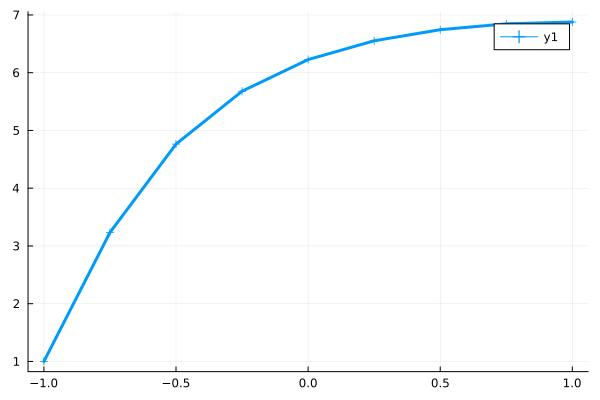

In [31]:
fe = FESpace(-1, 1, 3, 3, 4)
u0 = zero(fe.xn)
size(u0)
sol = nlsolve(u -> fe_residual(u, fe, fq), u0; method=:newton)
plot(fe.xn, sol.zero, marker=:auto)

# Finite element Jacobian assembly

$$ v^T F(u) \sim \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
$$ v^T J(u) du \sim \int_\Omega v\cdot df_0(u, du, \nabla u, \nabla du) + \nabla v\cdot df_1(u, du, \nabla u, \nabla du) = 0, \quad \forall v$$

In [32]:
function fe_jacobian(u_in, fe, dfq; bci=[1], bcv=[1.])
    u = copy(u_in); u[bci] = bcv
    rows, cols, vals = Int[], Int[], Float64[]
    for e in 1:fe.num_elem
        q, w, E, dXdx, B, D = fe_element(fe, e)
        P = fe.P
        ue = E * u
        uq = B * ue; Duq = dXdx .* (D * ue)
        K = zeros(P, P)
        for j in 1:fe.P
            du = B[:,j]
            Ddu = dXdx .* D[:,j]
            df0, df1 = dfq(q, uq, du, Duq, Ddu)
            K[:,j] = B' * (w .* df0) + D' * (dXdx .* w .* df1)
        end
        inds = rowvals(sparse(E'))
        append!(rows, kron(ones(P), inds))
        append!(cols, kron(inds, ones(P)))
        append!(vals, vec(K))
    end
    A = sparse(rows, cols, vals)
    A[bci, :] .= 0; A[:, bci] .= 0
    A[bci,bci] = diagm(ones(length(bci)))
    A
end

fe_jacobian (generic function with 1 method)

In [33]:
sol = nlsolve(u -> fe_residual(u, fe, fq),
    u -> fe_jacobian(u, fe, dfq),
    u0;
    method=:newton)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 * Zero: [1.0, 3.233066832934705, 4.763363332972802, 5.679478339657092, 6.227478131430273, 6.552900706733805, 6.744987353417804, 6.84638843314423, 6.878044892676181]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 2

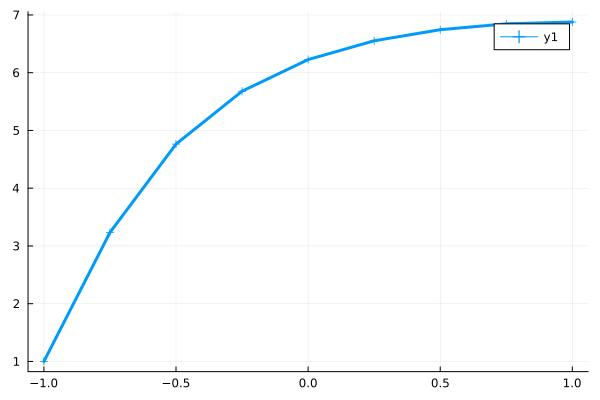

In [34]:
plot(fe.xn, sol.zero, marker=:auto)